In [ ]:
from pathlib import Path

import torch
import torchinfo
from torch import nn
from torch_geometric.datasets.citation_full import CitationFull
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.metrics.classification import IncrementalConfusionMatrix
from torchlake.graph.models.attention import GAT
from tqdm import trange

# setting

In [64]:
data_path = Path("../../data/citationFull")
artifacts_path = Path("../../artifacts/gat")

In [65]:
device = torch.device("cuda:0")

# data

In [66]:
dataset = CitationFull(data_path.as_posix(), 'DBLP')

In [67]:
dataset._data

Data(x=[17716, 1639], edge_index=[2, 105734], y=[17716])

In [68]:
X = dataset.x.to(device)
E = dataset.edge_index.T.to(device)
Y = dataset.y.to(device)

browse graph in gephi(a JAVA program)

In [69]:
# import networkx
# from torch_geometric.utils import to_networkx

In [70]:
# networkx.write_gexf(
#     to_networkx(dataset._data, to_undirected=True),
#     artifacts_path / "pubmed.gexf",
# )

# model

In [71]:
NODE_SIZE = dataset.x.size(0)
FEATURE_SIZE = dataset.num_node_features
LATENT_DIM = 8
LABEL_SIZE = dataset.num_classes

In [72]:
VERSION = 2

In [ ]:
model = GAT(
    FEATURE_SIZE,
    LATENT_DIM,
    LABEL_SIZE,
    num_layer=2,
    num_heads=8,
    version=VERSION,
).to(device)

In [74]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Gat                                      --
├─Dropout: 1-1                           --
├─ELU: 1-2                               --
├─ModuleList: 1-3                        --
│    └─GatLayerV2: 2-1                   105,024
│    └─GatLayerV2: 2-2                   2,112
Total params: 107,136
Trainable params: 107,136
Non-trainable params: 0

# train

In [75]:
epoch = 300

In [76]:
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [77]:
for e in trange(epoch):
    running_loss = 0.0
    
    optimizer.zero_grad()
    
    output = model.forward(X, E)
    loss = criterion.forward(output, Y)
    running_loss += loss.item()
    
    loss.backward()
    optimizer.step()
    
    print(f"epoch {e+1}: {running_loss / NODE_SIZE}")

  3%|▎         | 8/300 [00:00<00:09, 29.73it/s]

epoch 1: 12.117760781214722
epoch 2: 11.092772776021675
epoch 3: 10.108811420467374
epoch 4: 9.565902644502145
epoch 5: 9.59958864867916
epoch 6: 8.36644752624746
epoch 7: 7.8033045693158725
epoch 8: 7.14556006928765
epoch 9: 6.545944961475502
epoch 10: 6.232286051450666
epoch 11: 5.653106214015579
epoch 12: 4.997819326456311
epoch 13: 4.303917980215624


  7%|▋         | 20/300 [00:00<00:06, 45.07it/s]

epoch 14: 3.7368718601828856
epoch 15: 3.19872528716979
epoch 16: 2.7875977664963876
epoch 17: 2.309325786012644
epoch 18: 2.1228775365488826
epoch 19: 1.9683359145687513
epoch 20: 1.877880517611199
epoch 21: 1.8637041551422442
epoch 22: 1.8582762845027094
epoch 23: 1.819595237003274


 11%|█▏        | 34/300 [00:00<00:04, 53.99it/s]

epoch 24: 1.8153079754882593
epoch 25: 1.7402151921285842
epoch 26: 1.725816131956988
epoch 27: 1.6794107815675097
epoch 28: 1.745032738767216
epoch 29: 1.7461488731937231
epoch 30: 1.6085856358658839
epoch 31: 1.7929212338070106
epoch 32: 1.7747199962251636
epoch 33: 1.7130720905537367
epoch 34: 1.8075625052918265
epoch 35: 1.820994153413581
epoch 36: 1.6971113903039625
epoch 37: 1.7025036513603522
epoch 38: 1.600214186681531


 17%|█▋        | 50/300 [00:00<00:03, 65.43it/s]

epoch 39: 1.4621007096339467
epoch 40: 1.5577291978296455
epoch 41: 1.446090288263434
epoch 42: 1.423013293950384
epoch 43: 1.3916530475629374
epoch 44: 1.412435153074904
epoch 45: 1.3277756291981824
epoch 46: 1.4246058030170468
epoch 47: 1.3109871990714608
epoch 48: 1.3243614088253557
epoch 49: 1.2977052655438586
epoch 50: 1.3971120076837322
epoch 51: 1.3452615882182772
epoch 52: 1.2974937027263491
epoch 53: 1.3655582788863174
epoch 54: 1.2508421721537029


 22%|██▏       | 66/300 [00:01<00:03, 69.43it/s]

epoch 55: 1.249649526734308
epoch 56: 1.2475838401727253
epoch 57: 1.2340654281440506
epoch 58: 1.2063785913863174
epoch 59: 1.2027822439814293
epoch 60: 1.196339224606288
epoch 61: 1.2605135364924362
epoch 62: 1.2057918601123279
epoch 63: 1.1597535199466584
epoch 64: 1.1894480536661776
epoch 65: 1.197223400633608
epoch 66: 1.1652441207806503
epoch 67: 1.1566257196884173
epoch 68: 1.1540147544945247
epoch 69: 1.1724755120724204


 27%|██▋       | 82/300 [00:01<00:03, 72.27it/s]

epoch 70: 1.1387425429343532
epoch 71: 1.1392696309127341
epoch 72: 1.103560605526078
epoch 73: 1.103164710748758
epoch 74: 1.1100795846621698
epoch 75: 1.1262493120625423
epoch 76: 1.182227687013152
epoch 77: 1.1219338274723414
epoch 78: 1.1005322475093136
epoch 79: 1.0974026833088733
epoch 80: 1.0791765300434635
epoch 81: 1.1396284829038723
epoch 82: 1.105682627991646
epoch 83: 1.0590374917094716
epoch 84: 1.051504135562486
epoch 85: 1.0811039676351886
epoch 86: 1.047087665281384


 30%|███       | 90/300 [00:01<00:03, 66.80it/s]

epoch 87: 1.0650612440731542
epoch 88: 1.0857559241998758
epoch 89: 1.0595524525852338
epoch 90: 1.0343129753824227
epoch 91: 1.100867506773538
epoch 92: 1.063530693476236
epoch 93: 1.0107582834725672


 34%|███▍      | 103/300 [00:01<00:03, 53.71it/s]

epoch 94: 1.071335035243565
epoch 95: 0.9998709014803003
epoch 96: 1.0440395731612666
epoch 97: 1.0250706899836306
epoch 98: 1.0460107785688078
epoch 99: 1.0188109001044254
epoch 100: 1.0436992425632197
epoch 101: 1.0356599657442425
epoch 102: 1.0133140152263491
epoch 103: 0.9959871417433394
epoch 104: 1.0103962343361932
epoch 105: 1.0227231034093476
epoch 106: 0.9905921245272635


 40%|████      | 121/300 [00:02<00:02, 66.86it/s]

epoch 107: 0.9948142304272973
epoch 108: 1.0191023915528337
epoch 109: 0.9674498643528449
epoch 110: 0.9905678703220253
epoch 111: 1.0090884916883043
epoch 112: 0.9899027538665613
epoch 113: 0.9591887718023255
epoch 114: 0.969854007323888
epoch 115: 0.9472936275824114
epoch 116: 0.9714231441564123
epoch 117: 0.9388268152729171
epoch 118: 0.9574110488047528
epoch 119: 0.9908398481598555
epoch 120: 0.9464790170255701
epoch 121: 0.9877113864232897
epoch 122: 0.9845020038383382
epoch 123: 0.9520783207975841
epoch 124: 0.9866707707721833


 46%|████▋     | 139/300 [00:02<00:02, 74.28it/s]

epoch 125: 0.9820687558210093
epoch 126: 0.9708083000536238
epoch 127: 0.9519781068313954
epoch 128: 0.9506614342261233
epoch 129: 0.9457607618113569
epoch 130: 0.9281249779507225
epoch 131: 0.9948173173261459
epoch 132: 0.9204314889259708
epoch 133: 0.9453224221748702
epoch 134: 0.929183894502145
epoch 135: 0.9890259643472002
epoch 136: 0.9397339225488259
epoch 137: 0.9237541496740235
epoch 138: 0.9145271885230865
epoch 139: 0.9261932407498871
epoch 140: 0.9244349211165048
epoch 141: 0.9123121732297076


 49%|████▉     | 148/300 [00:02<00:01, 76.45it/s]

epoch 142: 0.9147713842712802
epoch 143: 0.9290872084203545
epoch 144: 0.8895136612913468
epoch 145: 0.9099629880828065
epoch 146: 0.908099162656638
epoch 147: 0.9148808038108207
epoch 148: 0.8868929392921653
epoch 149: 0.9185674981302213
epoch 150: 0.8894251885654211
epoch 151: 0.9139168093989896
epoch 152: 0.9019435556135696
epoch 153: 0.8781650084140042
epoch 154: 0.9100593434254346
epoch 155: 0.8994870456084895
epoch 156: 0.9149065463422894
epoch 157: 0.9105639411407767


 55%|█████▌    | 165/300 [00:02<00:01, 74.54it/s]

epoch 158: 0.8884670372121246
epoch 159: 0.8824465371168717
epoch 160: 0.8486730524314179
epoch 161: 0.8682386993043012
epoch 162: 0.8738592806290923
epoch 163: 0.8645264278230131
epoch 164: 0.8705196970605668
epoch 165: 0.8779495318497403
epoch 166: 0.8873342555811131
epoch 167: 0.8748763035532852
epoch 168: 0.869400696227986
epoch 169: 0.8639109222419
epoch 170: 0.8730609865375931
epoch 171: 0.8628771418668153
epoch 172: 0.8688951614183507
epoch 173: 0.8537891462872544


 61%|██████    | 182/300 [00:02<00:01, 75.47it/s]

epoch 174: 0.8453959785645744
epoch 175: 0.8718787042786182
epoch 176: 0.8564528643775401
epoch 177: 0.8636266519318695
epoch 178: 0.8502721762813276
epoch 179: 0.8611491951131746
epoch 180: 0.8642256205548656
epoch 181: 0.8442649057525683
epoch 182: 0.8755064167807349
epoch 183: 0.8328045732847426
epoch 184: 0.8692939226017442
epoch 185: 0.8423182852894276
epoch 186: 0.8736485997826823
epoch 187: 0.8398883446637221
epoch 188: 0.8768638254261685


 66%|██████▌   | 198/300 [00:03<00:01, 75.56it/s]

epoch 189: 0.8321046189708455
epoch 190: 0.8547965777757395
epoch 191: 0.8190560219222737
epoch 192: 0.8642895083363908
epoch 193: 0.8335016060693723
epoch 194: 0.8395646612701795
epoch 195: 0.8348906003048092
epoch 196: 0.8287987156736848
epoch 197: 0.826795373444203
epoch 198: 0.8303741916734872
epoch 199: 0.8343830810601999
epoch 200: 0.828350619231909
epoch 201: 0.8574795889838281
epoch 202: 0.825733369993932
epoch 203: 0.8086031760661266
epoch 204: 0.8300346328001524


 72%|███████▏  | 215/300 [00:03<00:01, 77.48it/s]

epoch 205: 0.8386594281828573
epoch 206: 0.8278862614479848
epoch 207: 0.8035614433986227
epoch 208: 0.8278060572011177
epoch 209: 0.8371155928962519
epoch 210: 0.8121955546010668
epoch 211: 0.8514962970443385
epoch 212: 0.8189968196122149
epoch 213: 0.8016923812690506
epoch 214: 0.8342916316818131
epoch 215: 0.7983209916177467
epoch 216: 0.8079482022783078
epoch 217: 0.8255404388159009
epoch 218: 0.8478936655953657
epoch 219: 0.8181606007634342


 77%|███████▋  | 232/300 [00:03<00:00, 76.96it/s]

epoch 220: 0.8484847516016595
epoch 221: 0.8281914785716301
epoch 222: 0.8201203956698747
epoch 223: 0.8254945763187231
epoch 224: 0.8101793686674476
epoch 225: 0.8193744686124125
epoch 226: 0.7984528462971325
epoch 227: 0.8171869597927015
epoch 228: 0.7943630360620343
epoch 229: 0.8114812682568018
epoch 230: 0.7936387724197054
epoch 231: 0.825206667877907
epoch 232: 0.7879645011042278
epoch 233: 0.8269475685820727
epoch 234: 0.8144455731224599
epoch 235: 0.7915892369538835
epoch 236: 0.8046310538496274


 83%|████████▎ | 249/300 [00:03<00:00, 78.45it/s]

epoch 237: 0.8309511110189941
epoch 238: 0.800204937009624
epoch 239: 0.792186166018712
epoch 240: 0.7833574148192312
epoch 241: 0.7734302788616223
epoch 242: 0.802893074674729
epoch 243: 0.8233639546349345
epoch 244: 0.7891125518599007
epoch 245: 0.788971105744807
epoch 246: 0.7769223331839862
epoch 247: 0.7750345291685482
epoch 248: 0.7971953760019191
epoch 249: 0.8250950434106176
epoch 250: 0.7870933892738202
epoch 251: 0.8079499662205069
epoch 252: 0.7779377024123674


 88%|████████▊ | 265/300 [00:03<00:00, 78.48it/s]

epoch 253: 0.788996186797951
epoch 254: 0.8241131339608264
epoch 255: 0.8036126528455916
epoch 256: 0.7722153636719632
epoch 257: 0.8062967665175548
epoch 258: 0.7970322113484986
epoch 259: 0.8074437148093532
epoch 260: 0.801429829497347
epoch 261: 0.7533796030071687
epoch 262: 0.7954442223837209
epoch 263: 0.7672366368148849
epoch 264: 0.7716229547090201
epoch 265: 0.7860749882697844
epoch 266: 0.7718738203636544
epoch 267: 0.7942335516799786
epoch 268: 0.7658208527072985
epoch 269: 0.7910095614486905


 94%|█████████▍| 282/300 [00:04<00:00, 75.64it/s]

epoch 270: 0.7945981916064574
epoch 271: 0.8130174414194795
epoch 272: 0.7820836831818695
epoch 273: 0.7618332959965568
epoch 274: 0.8099373778470027
epoch 275: 0.7820326391044818
epoch 276: 0.7462041066338339
epoch 277: 0.7432936571284432
epoch 278: 0.7871757433252428
epoch 279: 0.7810072925780368
epoch 280: 0.8022352896040302
epoch 281: 0.7502822858750564
epoch 282: 0.7865262818567961
epoch 283: 0.7782173423741251


 99%|█████████▉| 298/300 [00:04<00:00, 72.06it/s]

epoch 284: 0.7633300560757225
epoch 285: 0.7876917515416855
epoch 286: 0.7573804995307913
epoch 287: 0.7466621803736735
epoch 288: 0.7605412083356853
epoch 289: 0.7806102953368425
epoch 290: 0.7732659014979397
epoch 291: 0.8106729417440449
epoch 292: 0.753447239165867
epoch 293: 0.7685754689440336
epoch 294: 0.7681181118057123
epoch 295: 0.7634706753429104
epoch 296: 0.7647069783317341
epoch 297: 0.7607344702528788
epoch 298: 0.7568819102435651


100%|██████████| 300/300 [00:04<00:00, 67.59it/s]

epoch 299: 0.7854267946347934
epoch 300: 0.75273692169155


# evaluation

In [78]:
with torch.no_grad():
    model.eval()

    confusion_matrix = IncrementalConfusionMatrix(LABEL_SIZE)

    X = dataset.x.to(device)
    E = dataset.edge_index.T.to(device)
    output = model(X, E).argmax(-1)

    confusion_matrix.update(
        dataset.y.numpy(),
        output.view(-1).detach().cpu().numpy(),
    )

    print(confusion_matrix)

[[7099  493   52  276]
 [ 629 4656  156  204]
 [ 262  302 1375   43]
 [ 839  671   42  617]]


In [79]:
evaluator = ClassificationEvaluator(LABEL_SIZE, device)

In [80]:
per_class_accs = evaluator.get_per_class_accuracy(confusion_matrix)

evaluator.show_per_class_accuracy(range(LABEL_SIZE), per_class_accs)

0         : 0.8963383838383838
1         : 0.8248007085916741
2         : 0.6937436932391524
3         : 0.28446288612263715


In [81]:
per_class_accs.mean()

0.6748364179479618

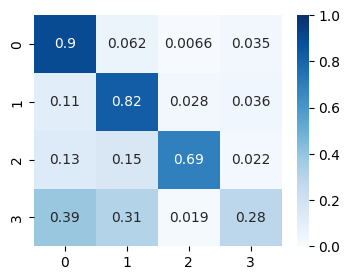

In [82]:
evaluator.plot_confusion_matrix(confusion_matrix, range(LABEL_SIZE), cmap='Blues')

# Save

In [83]:
model_path = artifacts_path.joinpath(f"gat.{VERSION}.pth")

In [84]:
torch.save(model.state_dict(), model_path)

In [85]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>